In [1]:
import torch
import torchvision
import collections
from collections import namedtuple

In [2]:
from attacks.analytic_attack import ImprintAttacker
from modifications.imprint import ImprintBlock
from utils.breaching_utils import *
from torchvision import transforms, datasets
import torch.nn as nn

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, h, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.ln1 = nn.LayerNorm([out_channels, h, h])
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.ln2 = nn.LayerNorm([out_channels, h, h])
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.LayerNorm([out_channels, h, h])
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.ln1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.ln2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out
            

class ResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet18, self).__init__()
        self.features = []
        self.initial = None
        self.classifier = []
        self.layers = collections.OrderedDict()
        self.in_channels = 64

        self.conv11 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias = False
        )
        self.features.append(self.conv11)
        self.layers['conv11'] = self.conv11
        
        self.ln1 = nn.LayerNorm([64, 16, 16])
        self.features.append(self.ln1)
        self.layers['LN1'] = self.ln1

        self.ReLU11 = nn.ReLU(True)
        self.features.append(self.ReLU11)
        self.layers['ReLU11'] = self.ReLU11
        
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.features.append(self.maxpool)
        self.layers['maxpool'] = self.maxpool
        
        self.layer1 = self._make_layer(
            block,
            64,
            8,
            layers[0],
            stride=1
        )
        self.features.append(self.layer1)
        self.layers['layer1'] = self.layer1
        
        self.layer2 = self._make_layer(
            block,
            128,
            4,
            layers[1],
            stride=2
        )
        self.features.append(self.layer2)
        self.layers['layer2'] = self.layer2
        
        self.layer3 = self._make_layer(
            block,
            256,
            2,
            layers[2],
            stride=2
        )
        self.features.append(self.layer3)
        self.layers['layer3'] = self.layer3
        
        self.layer4 = self._make_layer(
            block,
            512,
            1,
            layers[3],
            stride=2
        )
        self.features.append(self.layer4)
        self.layers['layer4'] = self.layer4
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.features.append(self.avgpool)
        self.layers['avgpool'] = self.avgpool
    
        self.feature_dims = 512
        self.fc = nn.Linear(self.feature_dims, num_classes)
        self.classifier.append(self.fc)
        self.layers['fc'] = self.fc

        self.initial_params = [param.data for param in self.parameters()]
        
    def _make_layer(self, block, out_channels, h, blocks, stride=1):
        layer_res = []
        layer_res.append(block(self.in_channels, out_channels, h, stride))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layer_res.append(block(out_channels, out_channels, h))
        
        return nn.Sequential(*layer_res)

    def forward(self, x):

        for idx, layer in enumerate(self.features[:]):
            x = layer(x)
    
        x = x.view(-1, self.feature_dims)
        for idx, layer in enumerate(self.classifier):
            x = layer(x)
        return x
 
    def get_params(self, end=9):
        params = []
        for layer in list(self.layers.values())[:end+1]:
            params += list(layer.parameters())
        return params

    def restore_initial_params(self):
        for param, initial in zip(self.parameters(), self.initial_params):
            param.data = initial

# Attack begins here:

### Initialize your model

In [4]:
setup = dict(device=torch.device("cuda:0"), dtype=torch.float)

# This could be any model:
#model = torchvision.models.resnet18()
model = ResNet18(block=BasicBlock, layers=[2, 2, 2, 2])
model.eval()
loss_fn = torch.nn.CrossEntropyLoss()
# It will be modified maliciously:
input_dim = data_cfg_default.shape[0] * data_cfg_default.shape[1] * data_cfg_default.shape[2]
num_bins = 100 # Here we define number of imprint bins
block = ImprintBlock(input_dim, num_bins=num_bins)
model = torch.nn.Sequential(
    torch.nn.Flatten(), block, torch.nn.Unflatten(dim=1, unflattened_size=data_cfg_default.shape), model
)
secret = dict(weight_idx=0, bias_idx=1, shape=tuple(data_cfg_default.shape), structure=block.structure)
secrets = {"ImprintBlock": secret}

### And your dataset (ImageNet by default)

In [5]:
transforms = torchvision.transforms.Compose(
    [
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=data_cfg_default.mean, std=data_cfg_default.std),
    ]
)
data_root = '/root/autodl-tmp'
trainset = datasets.CIFAR10(data_root+'/cifar', download=True, train=True, transform=transforms)
testset = datasets.CIFAR10(data_root+'/cifar', download=True, train=False, transform=transforms)
dataset = testset
batch_size = 64 # Number of images in the user's batch. We have a small one here for visualization purposes
import random
random.seed(123) # You can change this to get a new batch. 
samples = [dataset[i] for i in random.sample(range(len(dataset)), batch_size)]
data = torch.stack([sample[0] for sample in samples])
labels = torch.tensor([sample[1] for sample in samples])

Files already downloaded and verified
Files already downloaded and verified


### Simulate an attacked FL protocol

In [6]:
# This is the attacker:
attacker = ImprintAttacker(model, loss_fn, attack_cfg_default, setup)

# Server-side computation:
queries = [dict(parameters=[p for p in model.parameters()], buffers=[b for b in model.buffers()])]
server_payload = dict(queries=queries, data=data_cfg_default)
# User-side computation:
loss = loss_fn(model(data), labels)
shared_data = dict(
    gradients=[torch.autograd.grad(loss, model.parameters())],
    buffers=None,
    num_data_points=1,
    labels=labels,
    local_hyperparams=None,
)

### Reconstruct data from the update

In [7]:
# Attack:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, secrets, dryrun=False)

In [13]:
# Metrics?: 
from utils.analysis import report
#!pip uninstall pytorch_wavelets
true_user_data = {'data': data, 'labels': labels}
#print(reconstructed_user_data)
metrics = report(reconstructed_user_data,
    true_user_data,
    server_payload,
    model, compute_ssim=False) # Can change to true and install a package...
print(f"MSE: {metrics['mse']}, PSNR: {metrics['psnr']}, LPIPS: {metrics['lpips']}")

MSE: 0.03458305820822716, PSNR: 75.85469055175781, LPIPS: 0.1630215048789978


In [12]:
import pytorch_msssim
from pytorch_msssim import ssim
#print(results[0])
targets = true_user_data['data']
results = reconstructed_user_data['data']
sum = 0
for i in range(64):
    target = targets[i].unsqueeze(0)
    result = results[i].unsqueeze(0)
    #print(target)
    ssim_value = ssim(target.to('cpu'), result.to('cpu'), data_range=1.0, size_average=True, nonnegative_ssim=True)
    print(ssim_value)
    sum = sum + ssim_value

average_ssim = sum/64
print(f'ssim:{average_ssim}')

tensor(0.0004)
tensor(0.0005)
tensor(0.0088)
tensor(1.)
tensor(1.0000)
tensor(0.0263)
tensor(0.9588)
tensor(0.0001)
tensor(0.7392)
tensor(1.0000)
tensor(1.)
tensor(6.1001e-06)
tensor(1.0000)
tensor(1.)
tensor(1.)
tensor(2.2162e-05)
tensor(1.)
tensor(1.2078e-05)
tensor(0.9224)
tensor(0.0162)
tensor(2.2786e-05)
tensor(1.0000)
tensor(1.0000)
tensor(3.5547e-05)
tensor(0.9999)
tensor(1.2429e-05)
tensor(1.0000)
tensor(1.)
tensor(1.0000)
tensor(1.)
tensor(0.0004)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.0077)
tensor(1.)
tensor(4.7223e-06)
tensor(7.0224e-07)
tensor(1.)
tensor(1.)
tensor(1.0000)
tensor(1.0000)
tensor(0.3499)
tensor(0.)
tensor(2.3230e-05)
tensor(1.)
tensor(1.)
tensor(0.9865)
tensor(1.0000)
tensor(1.)
tensor(0.0004)
tensor(2.7890e-05)
tensor(1.0000)
tensor(1.0000)
tensor(6.8131e-05)
tensor(0.0430)
tensor(0.2818)
tensor(0.0331)
tensor(0.5842)
tensor(1.0000)
tensor(1.)
tensor(1.0000)
tensor(9.1483e-05)
ssim:0.5774966478347778


In [ ]:
### Plot ground-truth data

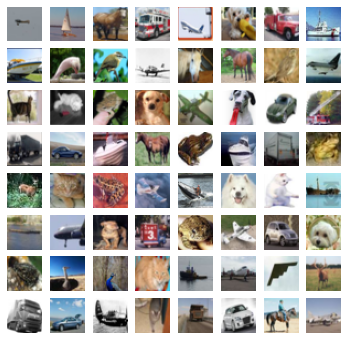

In [9]:
plot_data(data_cfg_default, true_user_data, setup)

### Now plot reconstructed data

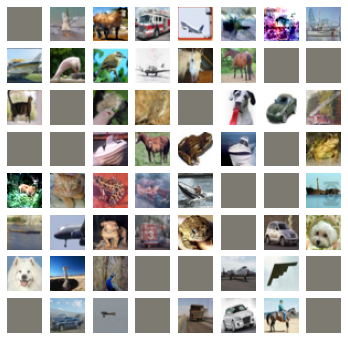

In [10]:
plot_data(data_cfg_default, reconstructed_user_data, setup)